# Contour Regularization
This part creates regularized building outlines from the pixel results outputted by the network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import text

## Contour finding with marching squares

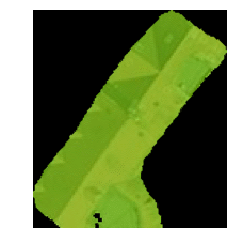

In [2]:
import os
p = os.path.join(os.getcwd(), "test", "data", "bigL.bmp")
image = plt.imread(p)

fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')  # clear x- and y-axes
plt.show()

No handles with labels found to put in legend.


max threshold:  62


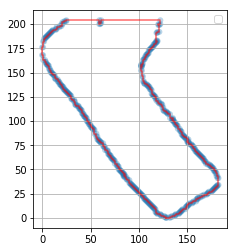

In [3]:
from core.utils import MarchingSquares

m = MarchingSquares.from_file(p)
points = m.find_contour(approximization_tolerance=0.01)
main_orientation = m.main_orientation(angle_in_degrees=True)

x = np.asarray(list(map(lambda p: p[0], points)))
y = np.asarray(list(map(lambda p: p[1], points)))

fig, ax = plt.subplots()
ax.set(aspect='equal')
ax.scatter(x, y, alpha=0.3, edgecolors='none')
plt.plot(x, y, color="red", alpha=0.6)

ax.legend()
ax.grid(True)

plt.show()

## Segmentation of the contour

From 533 points we got 44 line segments.


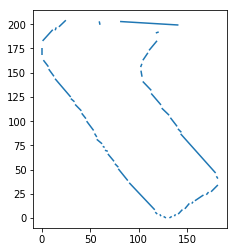

In [4]:
from core.utils import make_lines
from matplotlib import collections  as mc

lines = make_lines(points.copy(), 2)
print("From {} points we got {} line segments.".format(len(points), len(lines)))

lc = mc.LineCollection(map(lambda l: l.coords, lines))
fig, ax = plt.subplots()
ax.set(aspect='equal')
ax.add_collection(lc)
ax.autoscale()

## The line segments are then group by parallelity and perpendicularity...

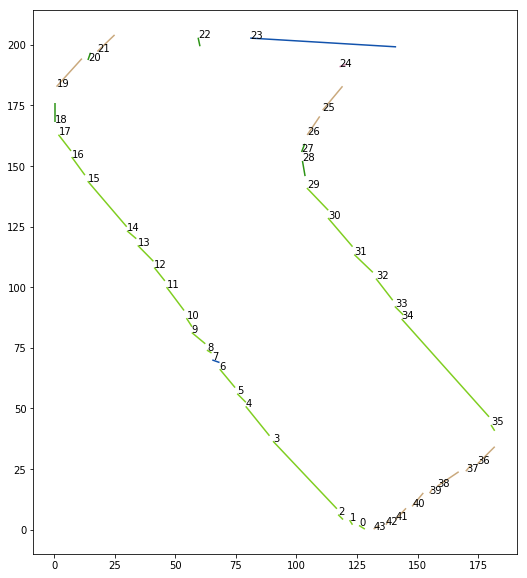

In [5]:
from core.utils import group_by_orientation

fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal')
grouped_lines = group_by_orientation(lines.copy())
for angle in grouped_lines:
    group = grouped_lines[angle]
    for ori in group:
        line_group = group[ori]
        for l in line_group:
            text(l.p1[0], l.p1[1], l.nr)
        lc = mc.LineCollection(map(lambda l: l.coords,line_group), colors=np.random.rand(3,))
        ax.add_collection(lc)
ax.autoscale()

## ...and after that, nearest neighbour clusters are created within each group

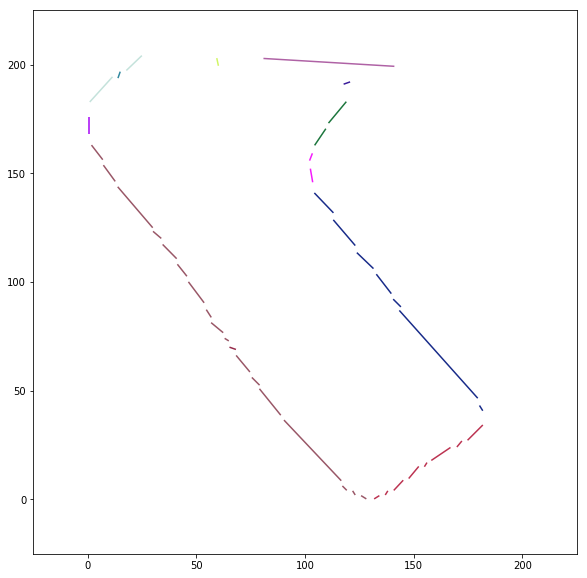

In [6]:
from core.utils import group_neighbours

import copy

new_groups = copy.deepcopy(grouped_lines)
group_neighbours(new_groups)

fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal')
for angle in new_groups:
    group = new_groups[angle]
    for ori in group:
        line_group = group[ori]
        for subgroup in line_group:
            lc = mc.LineCollection(map(lambda l: l.coords, subgroup), colors=np.random.rand(3,))
            ax.add_collection(lc)
            ax.set_xlim(-25, 225)
            ax.set_ylim(-25, 225)


 Line(nr=0, coords=((-25.860640691202953, 177.41440750209966), (153.2606384023846, -23.094407807275445)))

 Line(nr=7, coords=((63.61708269805433, 69.68797551451067), (69.88291730194567, 69.31202448548933)))

 Line(nr=18, coords=((0.02086046422959953, 164.01436130887066), (0.9791395357703987, 179.98563869112934)))

 Line(nr=19, coords=((-10.076027752232212, 173.29287310511103), (37.71602714188065, 215.98712567418585)))

 Line(nr=20, coords=((14.312024447649364, 192.1170820673898), (14.687975552350636, 198.38291793261024)))

 Line(nr=22, coords=((60.01691629833429, 204.81527214044362), (59.58308217578682, 197.58472175604078)))

 Line(nr=23, coords=((50.683747032180484, 204.61898434980708), (171.3162529678195, 197.3810156501929)))

 Line(nr=24, coords=((116.28863535613776, 190.46037263359955), (122.21136464386224, 192.53962736640045)))

 Line(nr=25, coords=((108.82142740743372, 170.4384734636919), (113.07856648905066, 174.24151921208934)))

 Line(nr=27, coords=((103.30589795694401, 160.

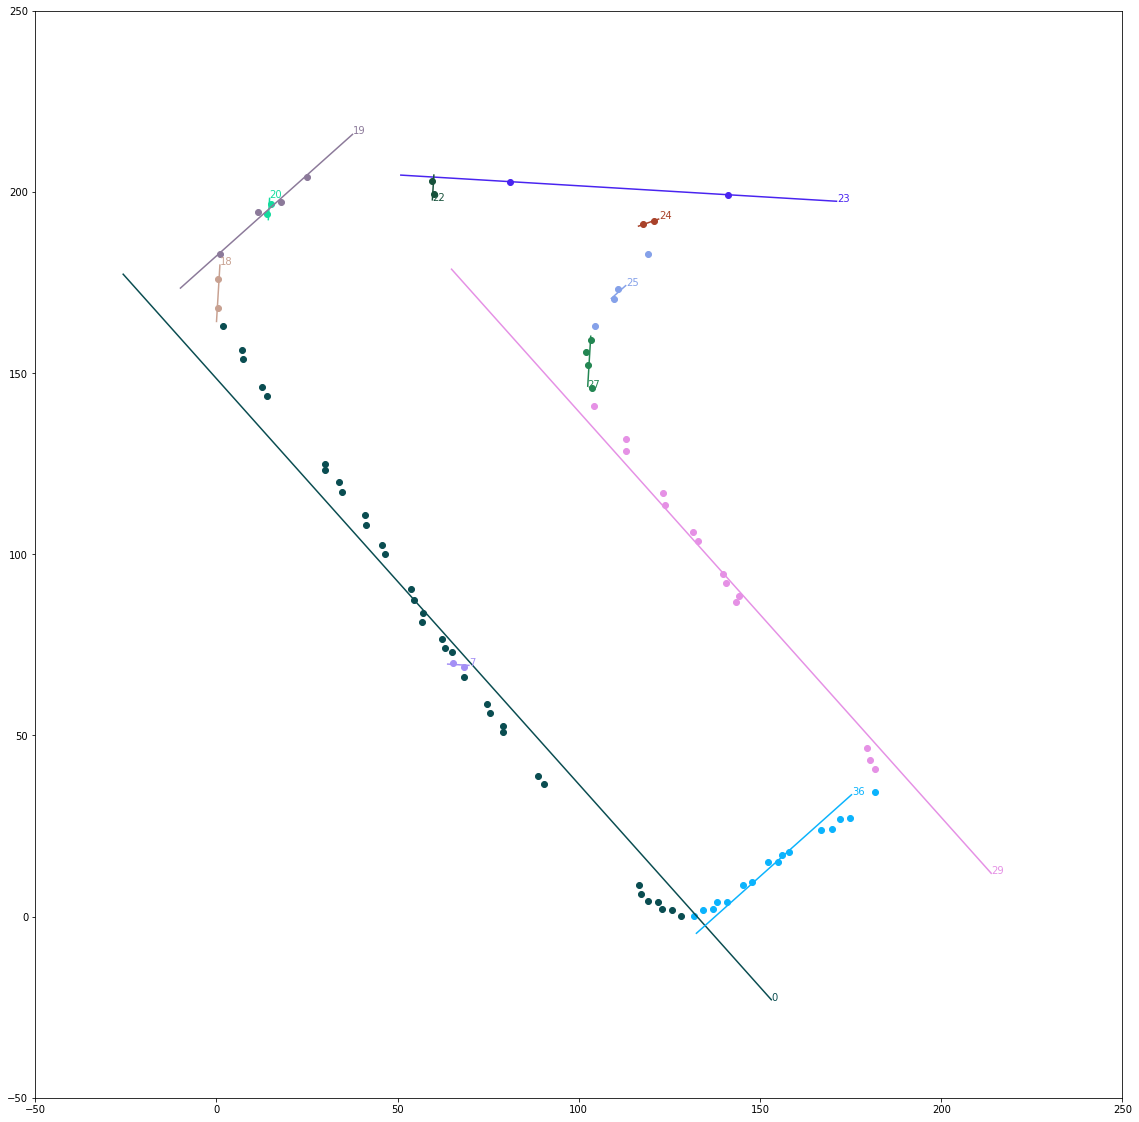

In [7]:
from scipy.optimize import curve_fit
import cv2
from core.utils import get_angle, Line
from shapely.affinity import rotate
from shapely import geometry

def make_fit_func(angle: float):
    def fit_line(x, m, b):
        a = angle
        return m * x + b
    return fit_line

fig, ax = plt.subplots(figsize=(20,20))
ax.set(aspect='equal')
fitted_lines = []
for angle in new_groups:
    group = new_groups[angle]
    for ori in group:
        line_group = group[ori]
        for subgroup in line_group:
            seg = []
            nr = min(map(lambda l: l.nr, subgroup))
            for l in subgroup:
                seg.extend(l.coords)
            line_angle = (angle if ori == "parallels" else angle - 90) % 180
            [vx, vy, x, y] = np.round(cv2.fitLine(points=np.asarray(seg), distType=cv2.DIST_L2, param=0, reps=0.01, aeps=0.01),2)
            dist = geometry.Point(seg[0]).distance(geometry.Point(seg[-1]))
            x1 = float(x - dist * vx)
            x2 = float(x + dist * vx)
            y1 = float(y - dist * vy)
            y2 = float(y + dist * vy)
            fitted_line = [(x1, y1), (x2, y2)]
            angle_delta = line_angle-get_angle(fitted_line)
            ls = rotate(geometry.LineString(fitted_line), angle_delta)

            color = np.random.rand(3,)
            xs = ls.coords.xy[0]
            ys = ls.coords.xy[1]
            x = np.asarray(list(map(lambda p: p[0], seg)))
            y = np.asarray(list(map(lambda p: p[1], seg)))
            fitted_line_new = [(xs[0], ys[0]), (xs[1], ys[1])]
            fitted_lines.append(Line(nr=nr, p1=fitted_line_new[0], p2=fitted_line_new[1]))
            lc = mc.LineCollection([fitted_line_new], colors=color)
            plt.scatter(x, y, color=color)
            ax.add_collection(lc)
            ax.set_xlim(-50, 250)
            ax.set_ylim(-50, 250)
            text(fitted_line_new[1][0], fitted_line_new[1][1], str(nr), color=color)

fitted_lines = sorted(fitted_lines, key=lambda l: l.nr)
for l in fitted_lines:
    print("\n", l)